## Determine longest trajectories

In [15]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import pickle

In [15]:
# Get the traj lengths
d_lengths = {}
for i in tqdm_notebook(range(1000)):
    path = f"/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone{i}.xtc"
    if os.path.exists(path):
        try: # note i'm using mdanalysis here because its faster than loading into mdtraj
            u = mda.Universe("/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone0.pdb", f"/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone{i}.xtc")
            n_frames = u.trajectory.n_frames
            d_lengths[i] = n_frames
        except:
            continue



  0%|          | 0/1000 [00:00<?, ?it/s]

Exception ignored in: <function ReaderBase.__del__ at 0x2abbb16cedc0>
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py", line 2152, in __del__
    self.close()
  File "/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py", line 179, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


In [82]:
with open("042021_lenghs.pickle", "wb") as f:
    pickle.dump(d_lengths, f)

In [16]:
with open("042021_lenghs.pickle", "rb") as f:
    d_lengths = pickle.load(f)

<AxesSubplot:ylabel='Density'>

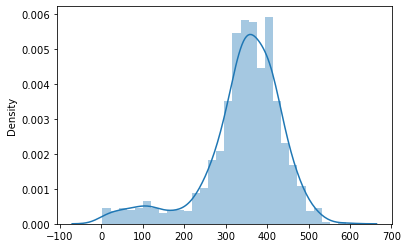

In [17]:
sns.distplot(list(d_lengths.values()))

In [18]:
long_trajs = [k for k, v in d_lengths.items() if v > 400]

In [19]:
len(long_trajs)

278

In [20]:
long_trajs

[2,
 6,
 7,
 8,
 9,
 10,
 11,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 27,
 31,
 32,
 35,
 37,
 40,
 41,
 42,
 44,
 45,
 47,
 50,
 51,
 52,
 54,
 56,
 60,
 63,
 68,
 72,
 74,
 76,
 82,
 83,
 84,
 85,
 92,
 93,
 95,
 97,
 101,
 107,
 108,
 109,
 111,
 115,
 124,
 131,
 133,
 136,
 141,
 152,
 156,
 158,
 160,
 161,
 162,
 164,
 165,
 166,
 167,
 168,
 171,
 179,
 181,
 184,
 190,
 207,
 208,
 212,
 213,
 215,
 219,
 226,
 232,
 236,
 240,
 241,
 243,
 247,
 248,
 249,
 252,
 254,
 256,
 262,
 264,
 276,
 281,
 284,
 285,
 290,
 293,
 294,
 295,
 304,
 306,
 311,
 325,
 328,
 332,
 335,
 336,
 340,
 350,
 351,
 353,
 354,
 355,
 357,
 360,
 361,
 363,
 366,
 367,
 372,
 377,
 379,
 380,
 381,
 384,
 391,
 397,
 398,
 399,
 409,
 411,
 417,
 422,
 424,
 429,
 430,
 439,
 447,
 455,
 459,
 466,
 469,
 471,
 475,
 478,
 485,
 488,
 489,
 504,
 506,
 511,
 514,
 515,
 522,
 527,
 529,
 533,
 546,
 548,
 559,
 563,
 568,
 570,
 579,
 582,
 588,
 598,
 601,
 604,
 608,
 609,
 610,
 6

## Compute distances between residues

In [1]:
import mdtraj as md
import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import time
from simtk.openmm import unit
import itertools
import numpy as np

### Test compute_contacts on clone6

In [2]:
top = md.load("/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone0.pdb")
path = "/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone6.xtc"
traj = md.load(path, top=top)


In [9]:
# Get neighboring residues
resid = 501
radius = 1

for res in top.topology.residues:
    if res.resSeq == resid and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
solute_atoms = list(traj.topology.select("is_protein"))
neighboring_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
neighboring_residues = set([atom.residue.index for atom in top.topology.atoms if atom.index in neighboring_atoms])

In [10]:
# Get all pairs of residues
pairs = []
for pair in itertools.combinations(neighboring_residues, 2):
    pairs.append(pair)

In [11]:
len(pairs)

1485

In [12]:
initial_time = time.time()
distances = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')
elapsed_time = (time.time() - initial_time) * unit.seconds
print(f'took: {elapsed_time / unit.seconds} seconds')

took: 5.296170711517334 seconds


### Run compute_contacts on trajectories with > 400 frames

In [21]:
distances_long = []
for i in tqdm_notebook(long_trajs):
    path = f"/data/chodera/glassw/covid_vir/PROJ17329/munged_data/run0-clone{i}.xtc"
    traj = md.load(path, top=top)
    distances = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')
    distances_long.append(distances)

  0%|          | 0/278 [00:00<?, ?it/s]

In [22]:
with open("042021_distances_1.pickle", "wb") as f:
    pickle.dump(distances_long, f)

In [23]:
distances_final = np.array([output[0] for output in distances_long])

In [73]:
for res in top.topology.residues:
    if res.index in neighboring_residues:
        print(res.index, res)

107 ASN439
164 GLY496
165 PHE497
166 GLN498
167 PRO499
168 THR500
169 ASN501
170 GLY502
171 VAL503
173 TYR505
174 GLN506
175 PRO507
229 TYR41
540 GLY352
541 LYS353
542 GLY354
543 ASP355


In [ ]:
# Question: should i discard the first X ns of data if im going to build an MSM?

In [ ]:
# See if using sidechain heavy atoms changes anything
distances = md.compute_contacts(traj, contacts=, scheme='sidechain-heavy')

In [ ]:
# See if using alpha carbons changes anything
distances = md.compute_contacts(traj, contacts=, scheme='ca')